In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

# Single scan, WITHOUT TT correction

In [67]:
fc = FileChooser('/sf/alvra/data/p19776/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19776/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [68]:
quantile_corr = 0.6

Timezero_mm = 37.02762 ## this in mm from the timescans 5.12 - 06:50 night
Timezero_mm = 36.990820
Timezero_mm = 37.060920 ## position as of 06:25 from timescan run0131 - 04.03.22

detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero117

#######################################################################################################33
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
flag = False

try:
    flag = True
    Timezero_mm = get_timezero_NBS(fc.selected)
except:
    Timezero_mm = Timezero_mm
    
(DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, 
 DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, 
 Izero_pump, Izero_unpump, correlation1, correlation2, Delay_mm, Delay_fs, goodshots1, goodshots2) = \
XAS_delayscan_noTT_2diodes(fc.selected, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr)
        
print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)

Processing: run0017
Step 35 of 35: Processing acq0035

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1999 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  1999 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY 1991 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1989 / 2001 -> 1% loss
complete channels: 1 / 4 -> 75% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 988 pump and 988 unpump shots
(356,) shots out of (988,) survived
(355,) shots out of (988,) survived
Step 35 of 35: Processed acq0035
correlation Diode1 (all shots) = 0.9978194957211229
correlation Diode2 (all shots) = 0.9976137395567055
------------------------------
Timezero found in file = 37.283020000044985 mm


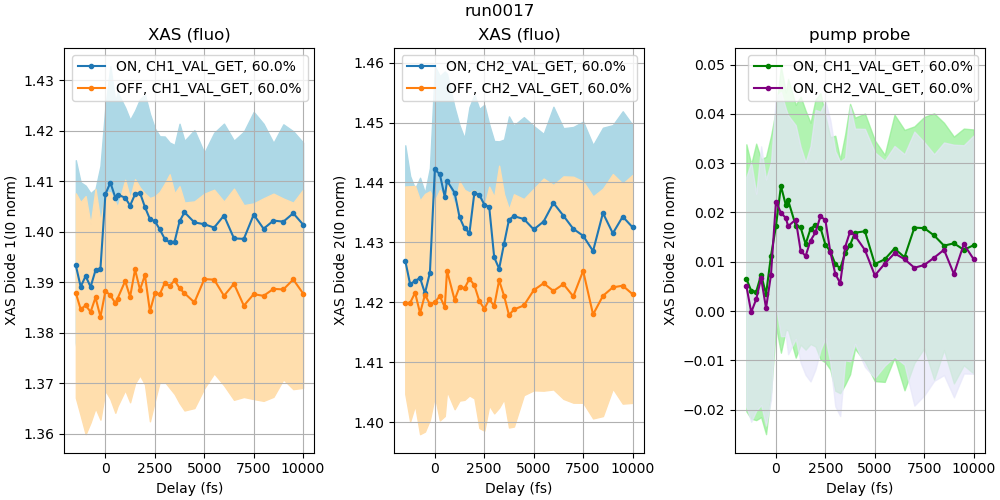

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-3], fontsize = 12)

#Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS1_pump = DataDiode1_pump[:,0]
err1_low_pump = DataDiode1_pump[:,1]
err1_high_pump = DataDiode1_pump[:,2]
XAS1_unpump = DataDiode1_unpump[:,0]
err1_low_unpump = DataDiode1_unpump[:,1]
err1_high_unpump = DataDiode1_unpump[:,2]
XAS1_pump_probe = Pump_probe_Diode1[:,0]
err1_low_pump_probe = Pump_probe_Diode1[:,1]
err1_high_pump_probe = Pump_probe_Diode1[:,2]

XAS2_pump = DataDiode2_pump[:,0]
err2_low_pump = DataDiode2_pump[:,1]
err2_high_pump = DataDiode2_pump[:,2]
XAS2_unpump = DataDiode2_unpump[:,0]
err2_low_unpump = DataDiode2_unpump[:,1]
err2_high_unpump = DataDiode2_unpump[:,2]
XAS2_pump_probe = Pump_probe_Diode2[:,0]
err2_low_pump_probe = Pump_probe_Diode2[:,1]
err2_high_pump_probe = Pump_probe_Diode2[:,2]

ax1.plot(Delay_fs, XAS1_pump, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err1_low_pump, err1_high_pump, color='lightblue')

ax1.plot(Delay_fs, XAS1_unpump, label='OFF, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err1_low_unpump, err1_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs, XAS2_pump, label='ON, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),marker='.')
ax2.fill_between(Delay_fs, err2_low_pump, err2_high_pump, color='lightblue')

ax2.plot(Delay_fs, XAS2_unpump, label='OFF, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),marker='.')
ax2.fill_between(Delay_fs, err2_low_unpump, err2_high_unpump, color='navajowhite')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("XAS Diode 2(I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

ax3.plot(Delay_fs, XAS1_pump_probe, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),color='green',marker='.')
ax3.fill_between(Delay_fs, err1_low_pump_probe, err1_high_pump_probe, alpha = 0.7, color='lightgreen')

ax3.plot(Delay_fs, XAS2_pump_probe, label='ON, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),color='purple',marker='.')
ax3.fill_between(Delay_fs, err2_low_pump_probe, err2_high_pump_probe, alpha = 0.7, color='lavender')

ax3.set_xlabel("Delay (fs)")
ax3.set_ylabel ("XAS Diode 2(I0 norm)")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

# ax1.set_ylim(1.068, 1.10)
# ax2.set_ylim(0.985, 1.015)
# ax3.set_ylim(-0.005, 0.02)
# for ax in [ax1, ax2, ax3]:
#     ax.set_xlim(-3000, 10000)

plt.show()

In [70]:
from scipy.special import erf
from scipy.optimize import curve_fit

def model_decay_2exp(t, t0, amp1, amp2, amp3, tau1, tau2, sigma, offset):
    return  0.5*(amp1 * np.exp((t0-t)/tau1 + 0.5*(sigma/tau1)**2)) * (1 + erf((t-(t0+sigma**2/tau1))/sigma*np.sqrt(2))) +\
            0.5*(amp2 * np.exp((t0-t)/tau2 + 0.5*(sigma/tau2)**2)) * (1 + erf((t-(t0+sigma**2/tau2))/sigma*np.sqrt(2))) +\
            0.5* amp3 * (1 + erf((t-t0)/(sigma*np.sqrt(2)))) + offset

In [71]:
print (XAS_pump_probe.max(), XAS_pump_probe.max(), XAS_pump_probe.max(), Delay_fs.mean()/2, Delay_fs.mean(), np.diff(Delay_fs).mean(), XAS_pump_probe.min())

0.025431211752560023 0.025431211752560023 0.025431211752560023 1653.429567883626 3306.859135767252 338.1555068614672 0.0003308220235243575


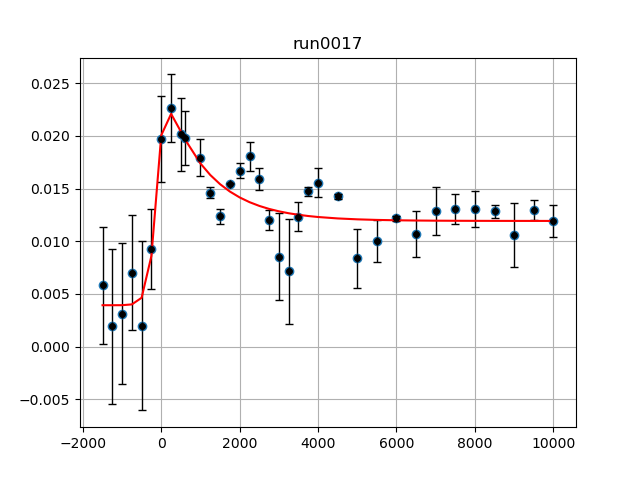

t0 = -150.4733685869558 fs
tau1 = 1119.1771953104762 fs
tau2 = 27.616180699167586 fs
width = 254.7218068576611 fs


In [74]:
XAS_pump_probe = (XAS1_pump_probe + XAS2_pump_probe)/2
XAS_err_l=np.sqrt(err1_low_pump_probe**2+err2_low_pump_probe**2)
XAS_err_h=np.sqrt(err1_high_pump_probe**2+err2_high_pump_probe**2)
XAS_errobar_l=(XAS_pump_probe-XAS_err_l)/np.sqrt(goodsho)
XAS_errobar_h=(XAS_err_h-XAS_pump_probe)/np.sqrt(16)

parameters,_ = curve_fit(model_decay_2exp, Delay_fs, XAS_pump_probe, p0 = [100, 0.08, 0.01, 0.015, 2000, 1000, 200, 0.0])
#parameters,_ = curve_fit(model_decay_2exp, Delay_fs, XAS_pump_probe, p0 = [-100, XAS_pump_probe.max(), XAS_pump_probe.max()/2, XAS_pump_probe.max()/2, Delay_fs.mean()/2, Delay_fs.mean(), np.diff(Delay_fs).mean(), XAS_pump_probe.min()])
plt.figure()
plt.title(fc.selected.split('/')[-3], fontsize = 12)
plt.plot(Delay_fs, XAS_pump_probe, 'o')
plt.errorbar(Delay_fs, XAS_pump_probe, XAS_errobar_l, XAS_errobar_h, 
             lw=0,color='k', marker='o', markersize=4,capsize=3,capthick=1,
                  ecolor='k',elinewidth=1,label='pump-probe')
plt.plot(Delay_fs, model_decay_2exp(Delay_fs,*parameters), color='r')
plt.grid()
plt.show()
print ("t0 = {} fs".format(parameters[0]))
print ("tau1 = {} fs".format(parameters[4]))
print ("tau2 = {} fs".format(parameters[5]))
print ("width = {} fs".format(parameters[6]))


(4740.44226025624, 0.07737800071281503, 249.95069533514783, 0.0026282904135491725)
[1.82629957e+03 1.13038727e-02 1.25734483e+03 2.33201876e-02]


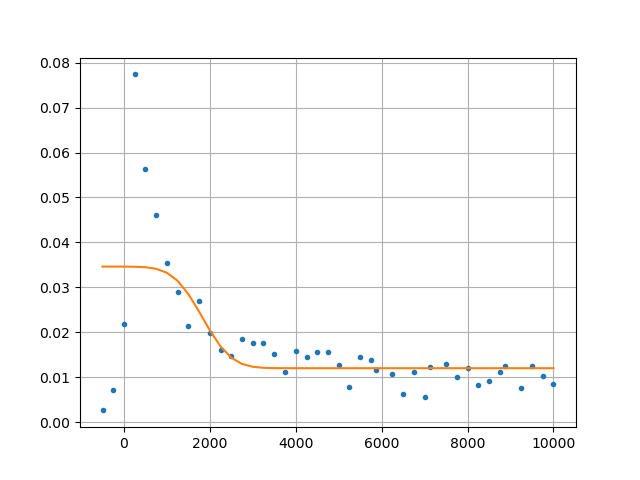

1826.2995712166987


In [13]:
XAS_pump_probe = (XAS1_pump_probe + XAS2_pump_probe)/2

# fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)

fit.estimate(Delay_fs, XAS_pump_probe)            # this sets some internal params 
# fit.p0 = better_p0(fit.p0, 0, -50) # overwrite some values (index) if needed: 
# fit.p0 = better_p0(fit.p0, 4, 300) # overwrite some values (index) if needed:
# fit.p0 = better_p0(fit.p0, 5, 1e-3) # overwrite some values (index) if needed:
# fit.p0 = better_p0(fit.p0, 6, 0.07) # overwrite some values (index) if needed:

print (fit.p0)

fit.fit(Delay_fs,XAS_pump_probe)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting
t0_fs = fit.popt[0]
width_fs = fit.popt[2]

print (fit.popt)

plt.figure()
plt.plot(Delay_fs, XAS_pump_probe, '.')
plt.plot(Delay_fs, pp_fit)
plt.grid()
plt.show()

print (t0_fs)

## Check correlation for a certain delay point

In [30]:
chosen_delay_fs = 8000

detector_XAS = channel_diode_1
detector_Izero = channel_Izero117

quantile_corr = 0.6
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)

index_delay = np.arange(len(Delay_fs))[(Delay_fs > chosen_delay_fs)][0]

(Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
 Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
Get_correlation_from_scan(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

print ('Delay = {:.2f} fs'.format(Delay_fs[index_delay]))

(183,) shots out of (500,) survived
Delay = 8000.20 fs


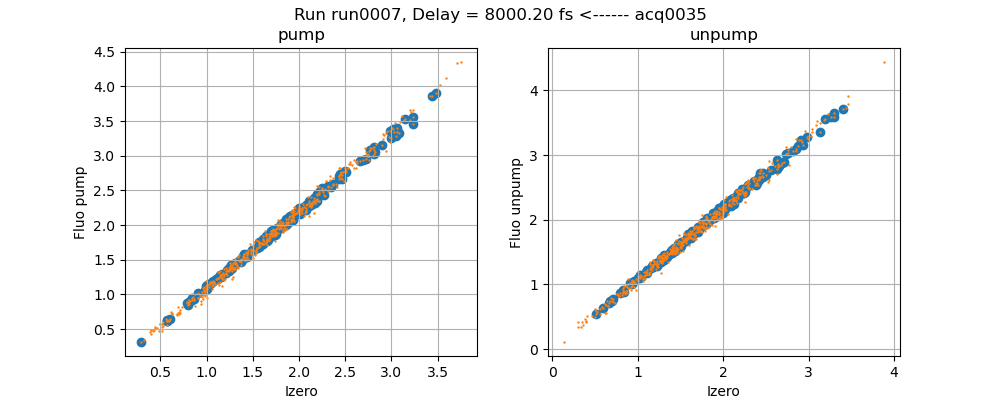

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle('Run {}, Delay = {:.2f} fs <------ {}'.format(fc.selected.split('/')[-3],Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Izero_pump_filter, Fluo_pump_filter)
plt.scatter(Izero_pump, Fluo_pump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo pump')
plt.grid()

plt.subplot(122)
plt.title('unpump')
plt.scatter(Izero_unpump_filter, Fluo_unpump_filter)
plt.scatter(Izero_unpump, Fluo_unpump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

# Loop of scans, WITHOUT TT correction

In [18]:
datafiles = []
for file in glob('/sf/alvra/data/p19262/raw/scan_info/*timescan_CpRhCO2_3002p8eV*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:-1]
patch

['/sf/alvra/data/p19262/raw/scan_info/067_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/073_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/083_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/089_timescan_CpRhCO2_3002p8eV.json']

In [17]:
quantile_corr = 0.6
Timezero_mm = 86.61422    ## this in mm from the YAG scans

detector_XAS = channel_diode_1
detector_Izero = channel_Izero122

#######################################################################################################33
from sfdata import SFScanInfo

DataDiode_pump_all = []
DataDiode_unpump_all = []
Pump_probe_all = []
Delay_fs_all = []

for json_file in patch:
    scan = SFScanInfo(json_file)
    
    DataDiode_pump = []
    DataDiode_unpump = []
    Pump_probe_Diode = []
    
    (DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,
     Izero_pump_scan, Izero_unpump_scan, correlation, Delay_mm, Delay_fs) = \
    XAS_delayscan_noTT(json_file, detector_XAS, detector_Izero, quantile_corr)
    
    DataDiode_pump_all.append(DataDiode_pump)
    DataDiode_unpump_all.append(DataDiode_unpump)
    Pump_probe_all.append(Pump_probe_Diode)

    Delay_fs_all.append(Delay_fs - mm2fs(Timezero_mm, 0))

DataDiode_pump_all = np.array(DataDiode_pump_all)
DataDiode_unpump_all = np.array(DataDiode_unpump_all)
Pump_probe_all = np.array(Pump_probe_all)
Delay_fs_all = np.array(Delay_fs_all)


/sf/alvra/data/p19262/raw/scan_info/067_timescan_CpRhCO2_3002p8eV.json

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1402 / 1402 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1402 / 1402 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 1402 / 1402 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1402 / 1402 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 701 pump and 701 unpump shots
(243,) shots out of (701,) survived
Step 25 of 55: Processed run_004571
correlation Diode (all shots) = 0.9933184995198263
Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_005658.JF02T09V02.res.h5
jungfrau file: 23:27 30.11.2021
pedestal file: 07:20 01.12.2021
    mtime difference: -7:52:47.710140


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


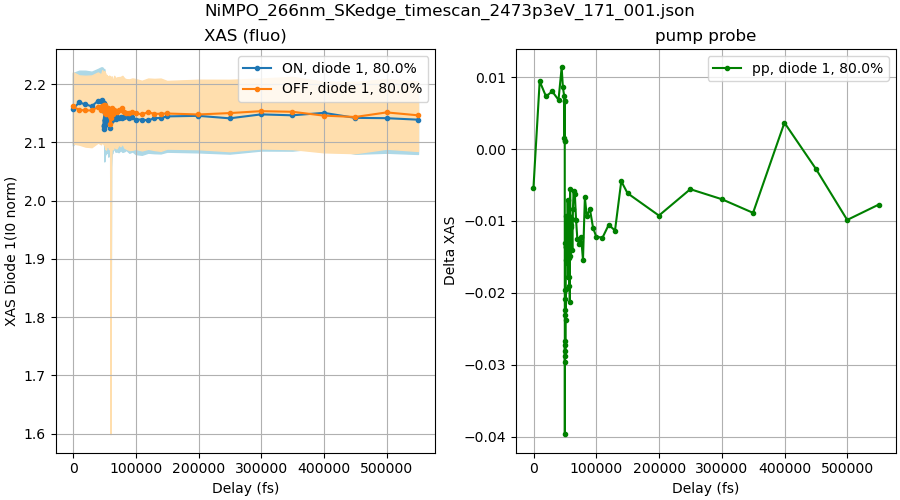

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

XAS_pump = np.mean(DataDiode_pump_all, axis=0)[:,0]
err_low_pump = (XAS_pump - np.mean(DataDiode_pump_all, axis=0)[:,1])/np.sqrt(len(patch))
err_high_pump = (np.mean(DataDiode_pump_all, axis=0)[:,2]-XAS_pump)/np.sqrt(len(patch))
XAS_unpump = np.mean(DataDiode_unpump_all, axis=0)[:,0]
err_low_unpump = (XAS_unpump - np.mean(DataDiode_unpump_all, axis=0)[:,1])/np.sqrt(len(patch))
err_high_unpump = (np.mean(DataDiode_unpump_all, axis =0)[:,2]-XAS_unpump)/np.sqrt(len(patch))
XAS_pump_probe = np.mean(Pump_probe_all, axis=0)[:,0]
err_low_pump_probe = np.mean(Pump_probe_all, axis=0)[:,1]#/np.sqrt(len(patch))
err_high_pump_probe = np.mean(Pump_probe_all, axis=0)[:,2]#/np.sqrt(len(patch))

Delay_fs_mean = np.mean(Delay_fs_all, axis=0)[:]

ax1.plot(Delay_fs_mean, XAS_pump, label='ON, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_pump - err_low_pump, XAS_pump + err_high_pump, color='lightblue')

ax1.plot(Delay_fs_mean, XAS_unpump, label='OFF, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_unpump - err_low_unpump, XAS_unpump + err_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs_mean, XAS_pump_probe, label='pp, diode 1, {}%'.format(quantile_corr*100),marker='.', color = 'g')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()